In [90]:
import cv2
import numpy as np
import imutils
import math
import matplotlib.pyplot as plt
import time

In [91]:
def extract_features(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Initialize ORB detector
    orb = cv2.ORB_create()

    # Find keypoints and descriptors in the image
    kp, des = orb.detectAndCompute(gray, None)
    return kp, des

In [92]:
def match_features(kp1, des1, kp2, des2):
    # Match features between the images
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Select the top matches
    num_good_matches = int(len(matches) * 0.90)
    matches = matches[:num_good_matches]

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = kp1[match.queryIdx].pt
        points2[i, :] = kp2[match.trainIdx].pt

    return points1, points2

In [93]:

def estimate_homography(points1, points2):
    # Find homography matrix
    H, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

    return H


In [94]:
def stitch_images(images):
    # Create stitching object
    stitcher = cv2.createStitcher() if cv2.__version__.startswith('3') else cv2.Stitcher_create()

    # Iterate over pairs of images and stitch them
    for i in range(1, len(images)):
        # Get the two images to stitch
        img1 = images[i-1]
        img2 = images[i]

        # Stitch the two images
        (status, stitched) = stitcher.stitch([img1, img2])

        # If stitching failed, print error message
        if status != cv2.Stitcher_OK:
            print(f"Image stitching failed: {status}")
            return None

        # Set the stitched image as the first image for next iteration
        images[i] = stitched

    # Resize final panorama to remove black borders
    result = cv2.resize(images[-1], (int(images[-1].shape[1] / 1.5), int(images[-1].shape[0] / 1.5)), interpolation=cv2.INTER_AREA)

    return result

In [95]:
def main():
    # Load images
    img1 = cv2.imread('data/xue-mountain/01.jpg')
    img2 = cv2.imread('data/xue-mountain/02.jpg')
    img3 = cv2.imread('data/xue-mountain/03.jpg')

    # Resize images
    size = (800, 600)
    img1 = cv2.resize(img1, size)
    img2 = cv2.resize(img2, size)
    img3 = cv2.resize(img3, size)

    # Start timer
    start_time = time.time()
    # Stitch images together
    result = stitch_images([img1, img2, img3])
        # End timer
    end_time = time.time()

    # Calculate processing time
    processing_time = end_time - start_time
    print("Processing time: {:.2f} seconds".format(processing_time))

    # Resize result to have the same size as img1
    result = cv2.resize(result, (img1.shape[1], img1.shape[0]))

    # Concatenate and resize original images
    original_imgs = np.concatenate((img1, img2, img3), axis=1)
    original_imgs_resized = cv2.resize(original_imgs, (result.shape[1], result.shape[0]))

    # Calculate MSE
    mse = np.mean((result - original_imgs_resized)**2)
    print("MSE: {:.2f}".format(mse))

    # Calculate PSNR
    psnr = 10 * math.log10((255 ** 2) / mse)
    print("PSNR: {:.2f} dB".format(psnr))

    # Display final result
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.show()

Processing time: 0.77 seconds
MSE: 84.19
PSNR: 28.88 dB


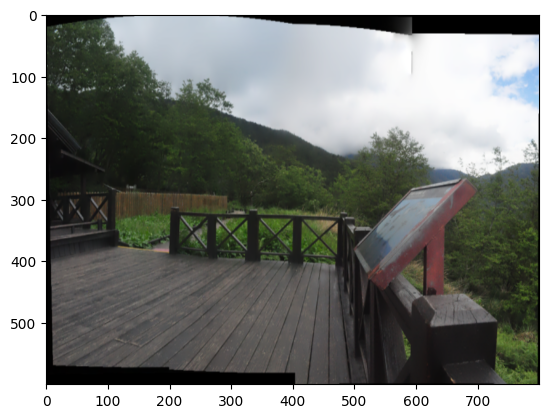

In [96]:
if __name__ == '__main__':
    main()